In [50]:
# Import necessary libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

# Define a custom class for a moving average cross strategy
class MovingAverageCrossStrategy:
    def __init__(self, symbol, short_window=5, long_window=21):
        # Initialize the strategy with the stock symbol and moving average window sizes
        self.symbol = symbol
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self, data):
        # Generate trading signals based on moving average crossovers
        signals = pd.DataFrame(index=data.index)
        signals['signal'] = 0.0

        # Create a short simple moving average
        signals['short_mavg'] = data['Close'].rolling(window=self.short_window, min_periods=1, center=False).mean()

        # Create a long simple moving average
        signals['long_mavg'] = data['Close'].rolling(window=self.long_window, min_periods=1, center=False).mean()

        # Generate buy (1.0) and sell (0.0) signals based on crossovers
        signals['signal'][self.short_window:] = np.where(
            signals['short_mavg'][self.short_window:] > signals['long_mavg'][self.short_window:],
            1.0,
            0.0
        )

        # Calculate the difference of signals to generate trading positions
        signals['positions'] = signals['signal'].diff()

        return signals

# Choose the stock symbol and date range for backtesting
symbol = 'AAPL'  # Stock symbol (Apple Inc.)
start_date = '2021-01-01'
end_date = '2023-08-02'

# Download historical stock data for the specified period using Yahoo Finance
data = yf.download(symbol, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


*  This code defines a custom class for a moving average crossover strategy. It calculates short and long moving averages of a given stock's closing prices, generates buy/sell signals based on crossovers, and calculates trading positions. The code then chooses the stock (in this case, AAPL) and a date range, downloads historical stock data, and is ready for backtesting the strategy.

In [51]:
# Create an instance of the MovingAverageCrossStrategy class
strategy = MovingAverageCrossStrategy(symbol='AAPL', short_window=10, long_window=21)

In [52]:
# Generate signals using the historical stock data
signals = strategy.generate_signals(data)

*  generates trading signals based on the moving average strategy using the historical stock data provided. The resulting signals are stored in the signals DataFrame.

In [53]:
# Print the signals DataFrame
print(signals)

            signal  short_mavg   long_mavg  positions
Date                                                 
2021-01-04     0.0  129.410004  129.410004        NaN
2021-01-05     0.0  130.209999  130.209999        0.0
2021-01-06     0.0  129.006666  129.006666        0.0
2021-01-07     0.0  129.484999  129.484999        0.0
2021-01-08     0.0  129.998000  129.998000        0.0
...            ...         ...         ...        ...
2023-07-26     1.0  192.999001  191.600000        0.0
2023-07-27     1.0  193.267001  191.845715        0.0
2023-07-28     1.0  193.781001  192.159048        0.0
2023-07-31     1.0  194.027000  192.485715        0.0
2023-08-01     1.0  194.215001  192.563810        0.0

[648 rows x 4 columns]


*  This part of the code prints the signals DataFrame, which contains information about the generated trading signals and moving averages.

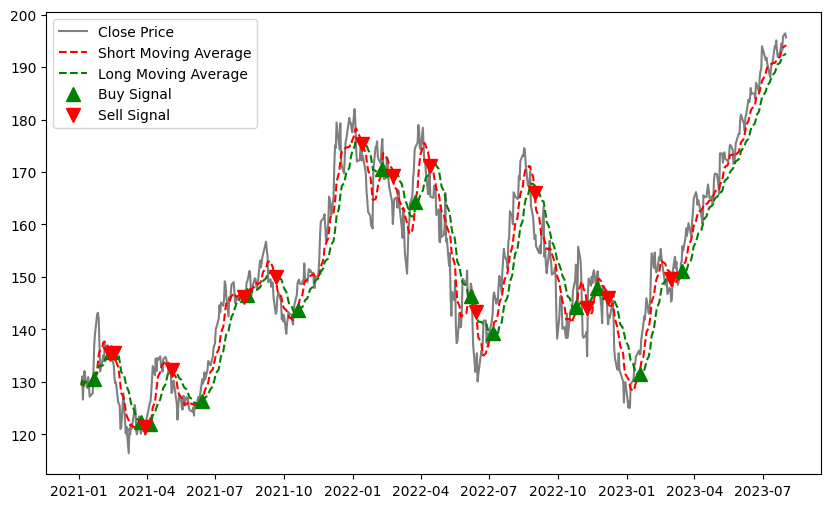

In [54]:
# Visualize the signals and moving averages
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price', color='black', alpha=0.5)
plt.plot(signals['short_mavg'], label='Short Moving Average', color='red', linestyle='dashed')
plt.plot(signals['long_mavg'], label='Long Moving Average', color='green', linestyle='dashed')
plt.plot(signals.loc[signals.positions == 1].index, signals.short_mavg[signals.positions == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(signals.loc[signals.positions == -1].index, signals.short_mavg[signals.positions == -1], 'v', markersize=10, color='r', label='Sell Signal')
plt.legend()
plt.show()

*  The code combines data analysis, signal generation, and visualization to evaluate the effectiveness of a moving average crossover strategy for the specified stock symbol (AAPL)

In [55]:
#This class represents a portfolio for backtesting a trading strategy. It initializes with parameters such as the stock symbol, historical data, and trading signals. It also sets various portfolio attributes like capital, number of shares, and performance metrics.
class Portfolio:
    def __init__(self, symbol, data, signals):
        self.symbol = symbol
        self.data = data
        self.signals = signals
        self.positions = self.signals['signal']
        self.capital = 1000000  # Initial capital for backtesting
        self.shares = 0
        self.net_profit = 0
        self.total_trades = 0
        self.wins = 0
        self.losses = 0
        self.risk_reward_ratio = 0
        self.max_drawdown = 0

#The backtest method iterates through the trading signals and executes buy or sell actions based on the signals.
    def backtest(self):
      for index, row in self.signals.iterrows():
        if row['positions'] == 1.0:  # Buy signal
            self.buy(index)
        elif row['positions'] == -1.0:  # Sell signal
            self.sell(index)

#The buy and sell methods simulate buying and selling shares based on the available capital and stock prices.
    def buy(self, date):
      if self.capital > 0:
        self.shares = self.capital / self.data.loc[date, 'Close']
        self.capital = 0
        self.total_trades += 1

    def sell(self, date):
      if self.shares > 0:
        self.capital = self.shares * self.data.loc[date, 'Close']
        self.shares = 0
        self.total_trades += 1

#The final portion of the code creates an instance of the Portfolio class, performs backtesting, and prints the backtest results, including net profit, win rate, loss rate, risk-reward ratio, and maximum drawdown.
    def evaluate(self):
      if self.total_trades > 0:
        self.net_profit = self.capital - 1000000
        self.wins = len(self.signals[self.signals['positions'] == 1.0])
        self.losses = len(self.signals[self.signals['positions'] == -1.0])
        self.risk_reward_ratio = self.net_profit / (self.wins * self.data['Close'].mean() - self.losses * self.data['Close'].mean())
        self.max_drawdown = (self.data['Close'].max() - self.data['Close'].min()) / self.data['Close'].max()


# Perform backtesting
portfolio = Portfolio(symbol, data, signals)
portfolio.backtest()
portfolio.evaluate()

# Print the backtest results
print("Backtest Results:")
print(f"Net Profit: {portfolio.net_profit}")
print(f"Win Rate: {portfolio.wins / portfolio.total_trades * 100:.2f}%")
print(f"Loss Rate: {portfolio.losses / portfolio.total_trades * 100:.2f}%")
print(f"Risk-Reward Ratio: {portfolio.risk_reward_ratio:.2f}")
print(f"Max Drawdown: {portfolio.max_drawdown * 100:.2f}%")

Backtest Results:
Net Profit: -1000000
Win Rate: 51.72%
Loss Rate: 48.28%
Risk-Reward Ratio: -6586.14
Max Drawdown: 40.77%


*  portfolio = Portfolio(symbol, data, signals): Here, you're creating an instance of the Portfolio class, passing in the symbol, historical data, and signals.

*  portfolio.backtest(): This line calls the backtest method on the portfolio instance. It initiates the backtesting process based on the provided data and signals.

*  portfolio.evaluate(): The evaluate method is called on the portfolio to calculate various performance metrics based on the backtest results.